In [3]:
!pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 2.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 4.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/245.0 kB 3.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 5.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 2.1 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.optim as optim

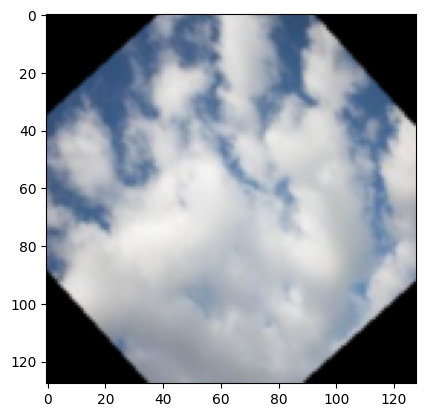

In [6]:
train_transforms = transforms.Compose([
    # Add horizontal flip and rotation
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

dataset_train = ImageFolder(
  "../data/clouds/clouds_train",
  transform=train_transforms,
)

dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=1
)

image, label = next(iter(dataloader_train))
# Reshape the image tensor
image = image.squeeze().permute(1, 2, 0) 
# Display the image
plt.imshow(image)
plt.show()

### Building convolutional networks
You are on a team building a weather forecasting system. As part of the system, cameras will be installed at various locations to take pictures of the sky. Your task is to build a model to classify different cloud types in these pictures, which will help spot approaching weather fronts.

You decide to build a convolutional image classifier. The model will consist of two parts:

A feature extractor that learns a vector of features from the input image,
A classifier that predicts the image's class based on the learned features.
Both torch and torch.nn as nn have already been imported for you, so let's get to it!

In [11]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # Define feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
        )
        # Define classifier
        self.classifier = nn.Linear(64*16*16, num_classes)
    
    def forward(self, x):  
        # Pass input through feature extractor and classifier
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

### Dataset with augmentations

In [18]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),    transforms.RandomRotation(45),    transforms.RandomAutocontrast(),    transforms.ToTensor(),    transforms.Resize((128, 128))])


dataset_train = ImageFolder(
  "../data/clouds/clouds_train",
  transform=train_transforms,
)
dataloader_train = DataLoader(
  dataset_train, shuffle=True, batch_size=16
)

dataset_test = ImageFolder(
  "../data/clouds/clouds_test",
  transform=train_transforms,
)
dataloader_test = DataLoader(
  dataset_test, shuffle=True, batch_size=16
)

### Image classifier training loop
It's time to train the image classifier! You will use the Net you defined earlier and train it to distinguish between seven cloud types.

To define the loss and optimizer, you will need to use functions from torch.nn and torch.optim, imported for you as nn and optim, respectively. You don't need to change anything in the training loop itself: it's exactly like the ones you wrote before, with some additional logic to print the loss during training.

In [13]:
# Define the model
net = Net(num_classes=7)
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)

for epoch in range(3):
    running_loss = 0.0
    # Iterate over training batches
    for images, labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(dataloader_train)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x65536 and 16384x7)

### Multiclass model evaluation

In [16]:
from torchmetrics import Precision, Recall
import torch

In [19]:
# Define metrics
metric_precision = Precision(task='multiclass', num_classes=7, average='micro')
metric_recall = Recall(task='multiclass', num_classes=7, average='micro')

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
        metric_recall(preds, labels)

precision = metric_precision.compute()
recall = metric_recall.compute()
print(f"Precision: {precision}")
print(f"Recall: {recall}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x65536 and 16384x7)

In [ ]:
# Define precision metric
metric_precision = Precision(
    task="multiclass", num_classes=7, average=None
)

net.eval()
with torch.no_grad():
    for images, labels in dataloader_test:
        outputs = net(images)
        _, preds = torch.max(outputs, 1)
        metric_precision(preds, labels)
precision = metric_precision.compute()

# Get precision per class
precision_per_class = {
    k: precision[v].item()
    for k, v 
    in dataset_test.class_to_idx.items()
}
print(precision_per_class)